# Recommender system

### 1.0  movielens small som består av 100,000 ratings på 9000 filmer och 600 användare
- downloading the dataset

In [259]:
import pandas as pd

movies = 'Data1/ml-latest-small/ml-latest-small/movies.csv'
ratings = 'Data1/ml-latest-small/ml-latest-small/ratings.csv'

# genre ingår inte .... 

df_movies = pd.read_csv(movies, usecols=['movieId','title'], dtype={'movieId':'int32', 'title':'str'})

In [260]:
df_movies.head()

df_movies.describe()

df_movies

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017)
9738,193583,No Game No Life: Zero (2017)
9739,193585,Flint (2017)
9740,193587,Bungo Stray Dogs: Dead Apple (2018)


In [261]:
df_ratings = pd.read_csv(ratings, usecols=['userId', 'movieId', 'rating'], dtype={'userId':'int32', 'movieId':'int32', 'rating':'float32'})

In [262]:
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [263]:
# 9:20 
from scipy.sparse import csr_matrix 

# skapa en compressed sparse representation av data

movies_uesers=df_ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)
mat_movies_users=csr_matrix(movies_uesers.values)

# denna har ochkså prövats med CSR matris, resulterande i samma resultat, sam används på hela datan

In [393]:
from sklearn.neighbors import NearestNeighbors
# Euclidean distance
# Manhattan distance
# Minowski distance
# cosine similarity

# sätt upp KNN modellen med cosine som avståndsmått/likhetsmått
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
model_knn.fit(mat_movies_users)


NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [478]:
from fuzzywuzzy import process
# recommender function, skriver ut filmnamnet. OBS, beroende på reindexering 
# så kan inte denna funktion återanvändas helt.
def recommender(movie_name, data, model, n_recommendations):
    model.fit(data)
    idx=process.extractOne(movie_name, df_movies['title'])[2]
    print('Movier selected:',df_movies['title'][idx],' Index', idx)
    print(' Searching for recommendations .....')
    distances, indices = model.kneighbors(data[idx], n_neighbors=n_recommendations)
    #print(distances, indices )
    print(indices )
    for i in indices:
        print(df_movies['title'][i].where(i!=idx))

recommender('Toy Story', mat_movies_users, model_knn, 20)



Movier selected: Toy Story (1995)  Index 0
 Searching for recommendations .....
[[   0 2353  418  615  224  314  322  910  546  963  968 3189  506  123
   257  897  815 1182   31  277]]
0                                             NaN
2353               24 7: Twenty Four Seven (1997)
418                             Blown Away (1994)
615                            Asfour Stah (1990)
224                              Drop Zone (1994)
314              Shawshank Redemption, The (1994)
322                              Tank Girl (1995)
910                             Spellbound (1945)
546                  Three Musketeers, The (1993)
963                          Small Wonders (1995)
968                           Maximum Risk (1996)
3189                   Different for Girls (1996)
506                           Program, The (1993)
123                 Flirting With Disaster (1996)
257     Star Wars: Episode IV - A New Hope (1977)
897                   Meet Me in St. Louis (1944)
815           

## 1.1 - Movielens full - EDA


Läs in dataseten "movies.csv" och "ratings.csv"



In [267]:

movies = 'Data2/ml-latest/ml-latest/movies.csv'
ratings = 'Data2/ml-latest/ml-latest/ratings.csv'

df_movies = pd.read_csv(movies, usecols=['movieId','title'], dtype={'movieId':'int32', 'title':'str'} )
df_ratings = pd.read_csv(ratings, usecols=['userId', 'movieId', 'rating'], dtype={'userId':'int32', 'movieId':'int32', 'rating':'float32'})

# 86,000 movies by 330,975 users.
# used but not shown in output, i.e. below
# df_movies.info()
# df_ratings.describe()
# df_ratings.head()




,userId,movieId,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0


In [268]:
import matplotlib.pyplot as plt
import seaborn as sns

# räkna om så att antal röster per film 
df_test=df_ratings.loc[(df_ratings.groupby(['movieId'])['userId'].count())]


# ta bara hänsyn till de som har fler än 1000 omdömmen, i.e. df_test2 -> filmer med fler än 1000 omdömmen
df_test2=df_test[df_test.index>1000]


In [269]:

# skapa två dataframes en med antalet röster/omdömmen, en med genomsnittligt antal röster
df_testc=df_ratings.groupby(['movieId'])['userId'].count()
df_testavg=df_ratings.groupby(['movieId'])['rating'].mean()

# slå i hop df antal röster (df_testc) med genomsnittligt omdömme (df_testavg)
df_abcd= pd.merge(df_testc,df_testavg, on='movieId', how='inner')

# fixa till så att index ochkolumnnamn blir lite bättre :-), 
# df2 har nu sammantagen info om antalet ratings och genomsnittlig rating
df_abcd.rename_axis('movieId').reset_index()
df2 = df_abcd.rename({'userId': 'Count'}, axis='columns')


In [270]:
df2.sort_values(by='Count', ascending=False)

,Count,rating
movieId,,
318,122296,4.416792
356,113581,4.068189
296,108756,4.191778
2571,107056,4.160631
593,101802,4.150287
...,...,...
230881,1,4.500000
230877,1,1.500000
230871,1,2.500000


a)  EDA

Gör en plot som visar antalet omdömmen mot genomsnittligt omdömme (finns det orsak att tro att ju fler omdömmen desto högre genomsnittligt betyg?)

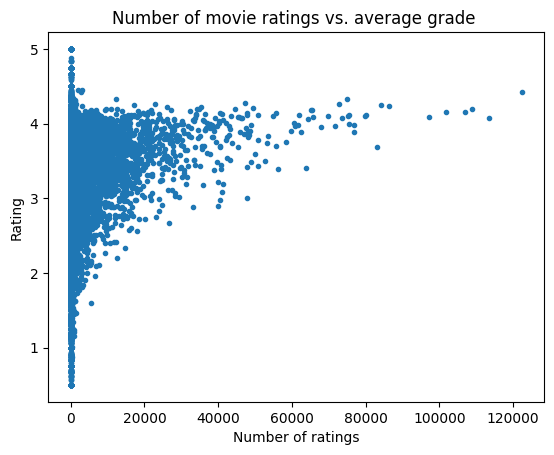

In [475]:
# df2 se tidigare (dataframe med antalet ratings och genomsnittlig rating per film)
plt.plot(df2['Count'], df2['rating'], '.')
plt.title('Number of movie ratings vs. average grade ')
plt.xlabel('Number of ratings')
plt.ylabel('Rating')
plt.show()

In more detail, the movies with highest average rating and their number of ratings

C:\Users\Lund\AppData\Local\Temp\ipykernel_7412\2100518864.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  snsplot.set_xticklabels(mytick, rotation=45, ha='right')


Text(0.5, 1.0, 'Number of ratings for top rated 100 movies and their average rating')

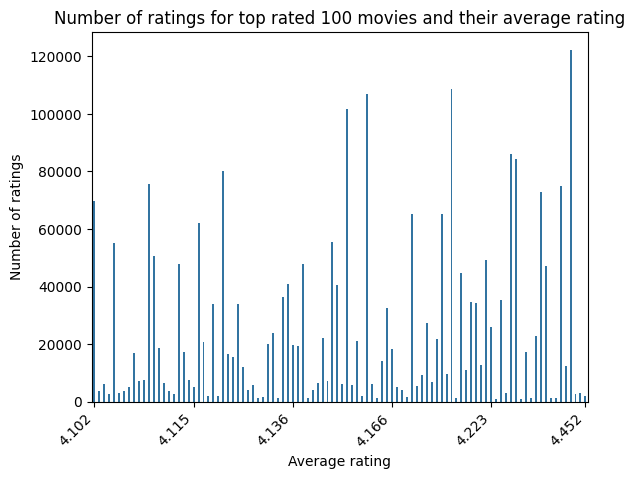

In [479]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker


# Filmer som har totalt fler än 1000 röster/ratings ...
df_all=df2[df2['Count']>1000].sort_values(by='rating',ascending = False)

# Skapa en plot som visar antalet ratings mot genomsnittligt betyg 
# illustrerar att det inte finns ett samband mellan fler röster och 
# ett högt genomsnittligt betyg, OBS bara för de 100 med högst genomsnitligt betyg
snsplot=sns.barplot(data = df_all.head(100), x = "rating", y = "Count", width=0.4)
# with som help from Stack Overflow, fix the xticks
tick_labels = [f'{float(label.get_text()):.3f}' for label in snsplot.get_xticklabels()]
# fixa xticklabels så att inte alla skrivs ut 
mytick=[] # labels
mytickpos=[] # position
for x in range(0,100,20):
    mytick.append(tick_labels[x])
    mytickpos.append(x)
# lägg till sista värdet
mytick.append(tick_labels[99])
mytickpos.append(99)
# rotera x labels och aligna labels
snsplot.set_xticklabels(mytick, rotation=45, ha='right')
# skriv ut vissa av labels, anges i mytickpos
snsplot.set_xticks(mytickpos)
# vad som finns på axlarna + titel
snsplot.set_xlabel('Average rating')
snsplot.set_ylabel('Number of ratings')
snsplot.set_title('Number of ratings for top rated 100 movies and their average rating')


b)  Vilka är de 10 filmerna med flest ratings

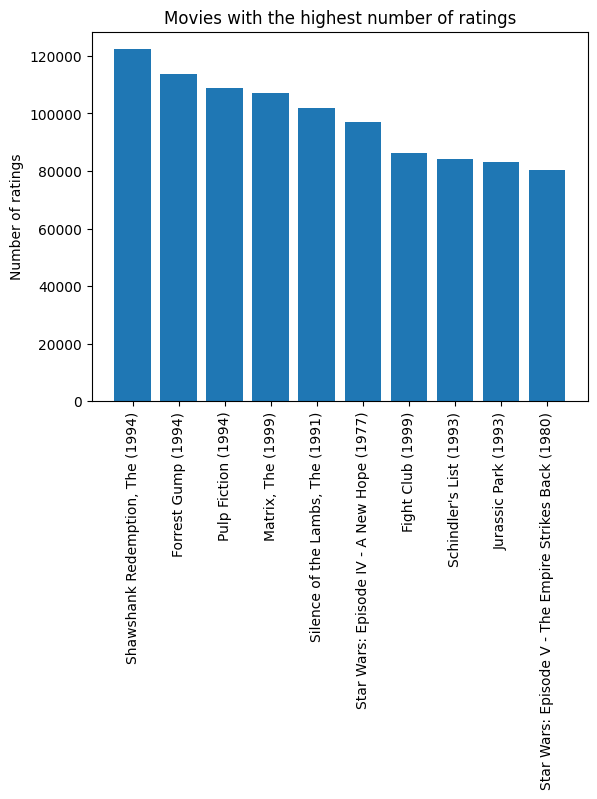

In [317]:
# sortera antalet ratings per film och ta top 10
top_10=df_all.sort_values(by='Count', ascending=False).head(10)

# fixa till df map index, dvs så att moviId inte är ett index
top_10s=top_10.rename_axis('movieId').reset_index()
 
# skapa en lista med filmnamnen på de 10 i top, denna används senare ....
namelist=[]
for i in list(top_10s['movieId']):
   namelist.append(df_movies[df_movies['movieId'] == i]['title'].values[0])


plt.bar(x=namelist, height=list(top_10s['Count']))
plt.xticks(rotation=90)
plt.ylabel('Number of ratings')
plt.title('Movies with the highest number of ratings')
plt.show()

c)  Genomsnittliga ratingen för dessa 10 filmerna med flest ratings.

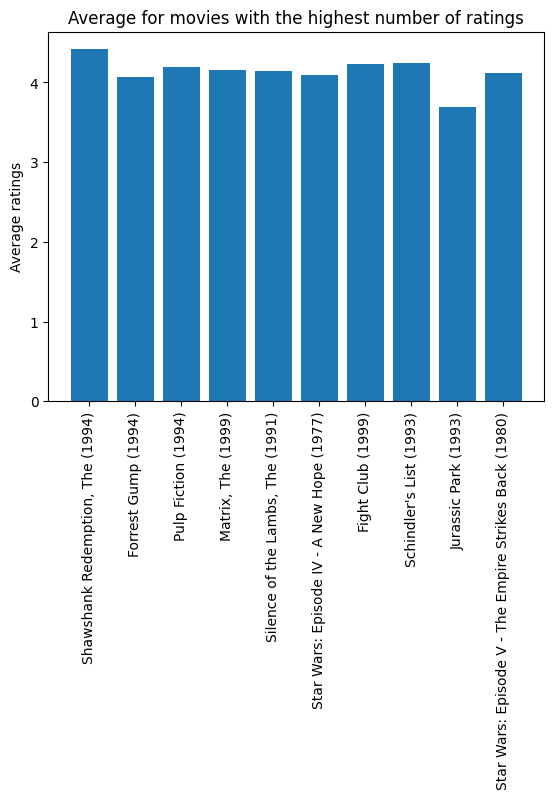

In [480]:
# I och med sammanslagningen och urvalet i tidigare uppgift så
# plottas nu istället genomsnittlig rating istället för antalet
plt.bar(x=namelist, height=list(top_10s['rating']))
plt.xticks(rotation=90)
plt.ylabel('Average ratings')
plt.title('Average for movies with the highest number of ratings')
plt.show()

d)  Gör en plot över årtal och antalet filmer representerade i datasetet.

[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Number of movies'),
 Text(0.5, 1.0, 'Movies per Year')]

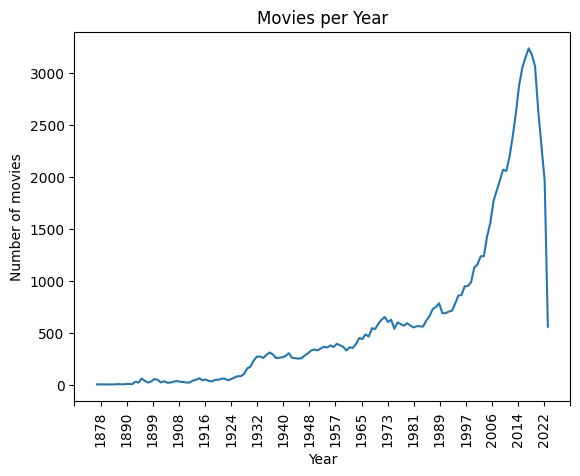

In [279]:
# Årtalet extraheras från filmtitel genom regexp uttryck - med hjälp från Stack Overflow
# för att räkan hur många filmer så används value_counts (hur många ggr värdet förekommer)
df_tmp=pd.DataFrame(df_movies['title'].str.extract(r'\((\d{4})\)').value_counts())
# fixa df map index och år, sorteras
df_years=df_tmp.rename_axis('years').reset_index().sort_values(by='years', ascending=True)

# plotta...
yearplot=sns.lineplot(df_years,x='years', y='count')
yearplot.tick_params(axis='x', rotation=90)
# använd ticker.linearlocator för att inte skriva ut alla år - hjälp från Stack Overlow
yearplot.xaxis.set_major_locator(ticker.LinearLocator(20))
yearplot.set(xlabel='Year', ylabel='Number of movies', title='Movies per Year')



f)  Beräkna genomsnittliga ratings för de top 10 filmerna med flest ratings. Gör ett stapeldiagram över dessa.

In [280]:
# se uppgift 1.1c (c) ovan

### 1.2 Skapa gles matris

In [354]:
import numpy as np
from scipy import sparse
# mat_movies_ratings=csr_matrix(np.array(data_sparse.T))

# Hjälp från Stack Overflow... Fixa först en COO matris som görs till en CSR (snabbare)
csr = sparse.coo_matrix(df_ratings.T).tocsr()



In [351]:
csr

<3x33832162 sparse matrix of type '<class 'numpy.float64'>'
	with 101496486 stored elements in Compressed Sparse Row format>

In [355]:
df_ratings['rating'].count()

33832162

In [352]:
from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
model_knn.fit(csr)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

### 1.3 Recommender system

In [388]:
from fuzzywuzzy import process
# recommender function
def recommender(movie_name, data, model, n_recommendations):
    model.fit(data)
    idx=process.extractOne(movie_name, df_movies['title'])[2]
    print('Movier selected:',df_movies['title'][idx],' Index', idx)
    print(' Searching for recommendations .....')
    distances, indices = model.kneighbors(data[idx], n_neighbors=n_recommendations)
    #print(distances, indices )
    for i in indices[0]:
        print(df_movies[df_movies.index==i]['title'].values[0])


related_movies=recommender('toy story', mat_movies_users, model_knn, 6)



Movier selected: Toy Story (1995)  Index 0
 Searching for recommendations .....
Toy Story (1995)
24 7: Twenty Four Seven (1997)
Blown Away (1994)
Asfour Stah (1990)
Drop Zone (1994)
Shawshank Redemption, The (1994)


a) hur systemet fungerar
- baserat på data från ratings (betyg) från kunder för filmer
- Genom att använda en KNN (närmaste grannar) så för att hitta rekommendationer till en film så plockas dessa grannar genom att hitta de 5 grannar som ligger närmast.
-  rekommendation för en film skapas genom att mäta avståndet till alla filmers rating och plocka ut de som ligger närmast, avståndet mäts genom en cosinus funktion. Cosinus funktionen bygger på att jämföra vektorn för inputfilmen med databasens vektorer. Vektorn bygger på featuren av alla användares ratings för de olika filmerna (totalt 33.832.162, dvs cirka 34 miljoner).
- det finns logiska fel i att bygga detta på ratingsvektorer där avståndet/vektorn mellan annan vektor avgör likhet. Till exempel, om vi vill ha rekommendationer for film x med rankingen (vektorn) <5,5,5,0,0,0> och jämför denna mot en film y i databasen med vektor <0,0,0,5,5,5> så kommer dessa att vara ortogonala (ingen likhet, inre produkt =0). Båda dessa har fått samma ranking 5 av tre användare. Däremot så kommer en ytterligare film (z) i databasen med t.ex. rankingen
<1,1,0,0,1,2> att bedömmas som "mer" relaterad till film x än film y. Detta får till följd att för film x så rekommenderas film z (med lägre betyg) än film x (med högre betyg)

b) Leta online och läs vidare om rekommenderarsystem och beskriv kort hur dem fungerar. Glöm inte
källhänvisa.

Det finns enligt NVIDIA (https://www.nvidia.com/en-us/glossary/recommendation-system/) tre olika kategorier av recommendersystem; collaborative filtering,  content filtering and context filtering.

### Collaborative filtering, dvs kollektiv filtrering:
Denna bygger på att produkter rekommenderas utifrån hur många andra personer bedömt produkter. Genom att använda sig av liknande användare (utifrån liknande köp, ranking av andra och liknande beslut av andra) så kan produkter rekommenderas. Tankesättet är att personer (grupp) som har gjort  liknande beslut, köp eller gillat en vara (film) kommer med hög sannolikhet att göra liknande beslut i framtiden. Om jag giller en typ av film och det finns en eller flera andra som gillar denna typ av film så kommer jag bli rekommenderad filmer som de andra personerna/gruppen gillar. 

### Content filtering, dvs innehållsfiltrering
Denna använder sig av attribut eller egenskaper för att rekommendera andra produkter/saker som  användaren/köparen föredrar. Innehållsfiltrering använder sig av likheten mellan varor/produkter och användarens egenskaper. Användarens egenskaper kan vara ålder och vad den tidigre har interagerat med (klick-historik, vad den har gillat i reviews, mm.). Genom att använda användarens egenskaper så kan man då rekommendera produkter/varor inom samma kategori (med samma innehåll). Om jag gillar star wars filmerna, så bör jag då bli rekomenderad andra sci-fi filmer t.ex. USS Enterprice

### Context filtering, kontextbaserad filtrering
I kontextbaserad filtrering används en tidigare sekvens av händelser/miljö/kontext tillsammans med nuvarande kontext för att prediciera sannolikheten för nästa händelse. Varje användare har sin egen kontexthistoria. I en kontext så kan bland annat var, när och hur ingå i kontexten. Om jag är hemma och det börjar närma sig jul och jag brukar titta på julfilmer så ska jag bli rekommenderad julfilmer. Har jag tittat på deckare vid jul, så ska jag bli rekommenderad deckare. Är jag inte hemma utan (på annan plattform eller annat land) så kan jag bli rekommenderat något annat.
